In [1]:
import pandas as pd
df = pd.read_csv('/Users/hwangjeonghyun/COVID-19-Machine-Learning/data/covid_preprocessed.csv')

In [2]:
df.head()

,SEX,PNEUMONIA,AGE,DIABETES,COPD,ASTHMA,INMSUPR,HIPERTENSION,OTHER_DISEASE,CARDIOVASCULAR,OBESITY,RENAL_CHRONIC,TOBACCO,DEATH,PREGNANT_CLEAN
0,1,1,65,2,2,2,2,1,2,2,2,2,2,1,No
1,2,1,72,2,2,2,2,1,2,2,1,1,2,1,NotApplicable
2,2,2,55,1,2,2,2,2,2,2,2,2,2,1,NotApplicable
3,1,2,53,2,2,2,2,2,2,2,2,2,2,1,No
4,2,2,68,1,2,2,2,1,2,2,2,2,2,1,NotApplicable


In [3]:
# 범주형 변수 (문자형 + 숫자 코드형)
categorical_cols = [
    'SEX','PREGNANT_CLEAN',
    'PNEUMONIA','DIABETES','COPD','ASTHMA','INMSUPR',
    'HIPERTENSION','OTHER_DISEASE','CARDIOVASCULAR',
    'OBESITY','RENAL_CHRONIC','TOBACCO'
]

# 원-핫 인코딩 (PATIENT_TYPE은 인코딩에서 제외)
X = pd.get_dummies(df.drop(columns=['DEATH']), 
                   columns=categorical_cols, drop_first=False)

# 타깃
y = df['DEATH']

print("최종 Feature shape:", X.shape)
print("Feature 예시:", X.columns[:50].tolist())


최종 Feature shape: (1048575, 40)
Feature 예시: ['AGE', 'SEX_1', 'SEX_2', 'PREGNANT_CLEAN_No', 'PREGNANT_CLEAN_NotApplicable', 'PREGNANT_CLEAN_Unknown', 'PREGNANT_CLEAN_Yes', 'PNEUMONIA_1', 'PNEUMONIA_2', 'PNEUMONIA_99', 'DIABETES_1', 'DIABETES_2', 'DIABETES_Unknown', 'COPD_1', 'COPD_2', 'COPD_Unknown', 'ASTHMA_1', 'ASTHMA_2', 'ASTHMA_Unknown', 'INMSUPR_1', 'INMSUPR_2', 'INMSUPR_Unknown', 'HIPERTENSION_1', 'HIPERTENSION_2', 'HIPERTENSION_Unknown', 'OTHER_DISEASE_1', 'OTHER_DISEASE_2', 'OTHER_DISEASE_Unknown', 'CARDIOVASCULAR_1', 'CARDIOVASCULAR_2', 'CARDIOVASCULAR_Unknown', 'OBESITY_1', 'OBESITY_2', 'OBESITY_Unknown', 'RENAL_CHRONIC_1', 'RENAL_CHRONIC_2', 'RENAL_CHRONIC_Unknown', 'TOBACCO_1', 'TOBACCO_2', 'TOBACCO_Unknown']


In [4]:
# 라이브러리, 기본 설정
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import (accuracy_score, roc_auc_score, f1_score, precision_score, recall_score,
                             classification_report, confusion_matrix, average_precision_score)
from sklearn.utils import shuffle
from joblib import dump, load
import lightgbm as lgb
import json, os

# 설정
GLOBAL_RS = 42
N_RUNS = 10   # 반복 횟수
ARTIFACT_DIR = "./modeling_artifacts"
os.makedirs(ARTIFACT_DIR, exist_ok=True)

In [5]:
# 데이터 6:2:2 분할
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.4, random_state=GLOBAL_RS, stratify=y
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=GLOBAL_RS, stratify=y_temp
)

print("Train:", X_train.shape, "Val:", X_val.shape, "Test:", X_test.shape)
print("사망 비율 — train:{:.4f}  val:{:.4f}  test:{:.4f}".format(
    np.mean(y_train), np.mean(y_val), np.mean(y_test)))


Train: (629145, 40) Val: (209715, 40) Test: (209715, 40)
사망 비율 — train:0.0734  val:0.0734  test:0.0734


In [12]:
# 하이퍼파라미터 탐색 (LightGBM, 최소 필수만 + 조기종료)
import warnings
from sklearn.exceptions import ConvergenceWarning, FitFailedWarning
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=ConvergenceWarning)
warnings.filterwarnings("ignore", category=FitFailedWarning)

base = lgb.LGBMClassifier(
    objective="binary",
    boosting_type="gbdt",
    n_jobs=-1,
    random_state=GLOBAL_RS,
    # 고정값: 조기종료와 함께 사용
    learning_rate=0.05,
    max_depth=-1,
    n_estimators=2000,   # 충분히 크게 두고 early_stopping으로 최적 반복에서 멈춤
    verbosity=-1
)

# 꼭 필요한/영향 큰 것들만 간단 탐색 (총 2*2*2*2*2 = 32조합)
param_grid = {
    "num_leaves": [31, 63],
    "min_child_samples": [20, 100],
    "subsample": [0.8, 1.0],
    "colsample_bytree": [0.8, 1.0],
    "reg_lambda": [0.0, 1.0],   # L2 정규화 강도
}

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=GLOBAL_RS)
grid = GridSearchCV(
    estimator=base,
    param_grid=param_grid,
    scoring="roc_auc",
    cv=cv,
    n_jobs=-1,
    verbose=0,
    refit=True
)

# 조기 종료를 위해 검증 세트를 eval_set으로 고정 전달
grid.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    eval_metric="auc",
    callbacks=[lgb.early_stopping(100), lgb.log_evaluation(0)]
)

best_params_fixed = grid.best_params_
best_cv_auc = grid.best_score_
print("Best params (fixed):", best_params_fixed)
print("CV AUC (Train CV):", best_cv_auc)


Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[138]	valid_0's auc: 0.923586	valid_0's binary_logloss: 0.157839
Early stopping, best iteration is:
[138]	valid_0's auc: 0.923586	valid_0's binary_logloss: 0.157839
Early stopping, best iteration is:
[139]	valid_0's auc: 0.923369	valid_0's binary_logloss: 0.157994
Early stopping, best iteration is:
[139]	valid_0's auc: 0.923369	valid_0's binary_logloss: 0.157994
Early stopping, best iteration is:
[156]	valid_0's auc: 0.923409	valid_0's binary_logloss: 0.157924
Earl

In [13]:
# 고정된 HP로 10회 학습(시드만 변경) → Val에서 베스트 선택 + 체크포인트 저장 (LightGBM)
run_records = []
best_val_auc = -np.inf
best_run_idx = -1
best_model = None
best_iter_for_ckpt = None

for rseed in range(N_RUNS):
    print(f"\n=== Fixed-HP Run {rseed+1}/{N_RUNS} ===")

    # 시드별로 Train만 섞어 학습
    X_tr, y_tr = shuffle(X_train, y_train, random_state=rseed)

    # LightGBM 모델 (그리드서치에서 얻은 best_params_fixed 사용)
    model = lgb.LGBMClassifier(
        **best_params_fixed,
        objective="binary",
        n_jobs=-1,
        class_weight="balanced",
        random_state=rseed,      # 시드만 변경
        verbosity=-1
    )

    # 조기 종료로 최적 반복 결정 (Val 사용)
    model.fit(
        X_tr, y_tr,
        eval_set=[(X_val, y_val)],
        eval_metric="auc",
        callbacks=[lgb.early_stopping(100), lgb.log_evaluation(0)]
    )

    # 최적 반복에서 예측
    best_iter = model.best_iteration_
    val_prob = model.predict_proba(X_val, num_iteration=best_iter)[:, 1]
    val_auc  = roc_auc_score(y_val, val_prob)
    val_pred05 = (val_prob >= 0.5).astype(int)

    rec = {
        "run": rseed,
        "val_auc": float(val_auc),
        "val_acc@0.5": float(accuracy_score(y_val, val_pred05)),
        "val_f1@0.5": float(f1_score(y_val, val_pred05)),
        "val_recall@0.5": float(recall_score(y_val, val_pred05)),
        "val_precision@0.5": float(precision_score(y_val, val_pred05)),
        "best_iteration": int(best_iter) if best_iter is not None else None
    }
    run_records.append(rec)
    print(f"VAL AUC: {val_auc:.4f} (best_iter={best_iter})")

    # 베스트 갱신 시 즉시 저장(체크포인트)
    if val_auc > best_val_auc:
        best_val_auc = val_auc
        best_model = model
        best_run_idx = rseed
        best_iter_for_ckpt = best_iter

        # joblib로 모델 저장
        dump(best_model, f"{ARTIFACT_DIR}/best_checkpoint_lgbm.joblib")

        # LightGBM 텍스트 모델도 함께 저장(선택)
        try:
            best_model.booster_.save_model(f"{ARTIFACT_DIR}/best_checkpoint_lgbm.txt")
        except Exception:
            pass

        # 메타 저장
        with open(f"{ARTIFACT_DIR}/checkpoint_meta_lgbm.json", "w") as f:
            json.dump({
                "selected_run": int(best_run_idx),
                "best_val_auc": float(best_val_auc),
                "fixed_best_params": best_params_fixed,
                "best_iteration": int(best_iter_for_ckpt) if best_iter_for_ckpt is not None else None
            }, f, ensure_ascii=False, indent=2)

        print(f"[Checkpoint saved] Run {best_run_idx}, VAL AUC={best_val_auc:.4f}, best_iter={best_iter_for_ckpt}")

top3 = sorted(run_records, key=lambda x: x["val_auc"], reverse=True)[:3]
print("\nTop runs by VAL AUC:\n", top3)



=== Fixed-HP Run 1/10 ===
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[81]	valid_0's auc: 0.923607	valid_0's binary_logloss: 0.360485
VAL AUC: 0.9236 (best_iter=81)
[Checkpoint saved] Run 0, VAL AUC=0.9236, best_iter=81

=== Fixed-HP Run 2/10 ===
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[70]	valid_0's auc: 0.923641	valid_0's binary_logloss: 0.360679
VAL AUC: 0.9236 (best_iter=70)
[Checkpoint saved] Run 1, VAL AUC=0.9236, best_iter=70

=== Fixed-HP Run 3/10 ===
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[81]	valid_0's auc: 0.923644	valid_0's binary_logloss: 0.360545
VAL AUC: 0.9236 (best_iter=81)
[Checkpoint saved] Run 2, VAL AUC=0.9236, best_iter=81

=== Fixed-HP Run 4/10 ===
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[8

In [14]:
# 임계값 최적화 (F1 기준, Val만 사용) — LightGBM 버전
def find_best_threshold_by_f1(y_true, y_prob, grid=np.linspace(0.05, 0.95, 37)):
    best_f1, best_t = -1.0, 0.5
    for t in grid:
        pred = (y_prob >= t).astype(int)
        f1 = f1_score(y_true, pred)
        if f1 > best_f1:
            best_f1, best_t = f1, t
    return best_t, best_f1

# LightGBM은 조기 종료를 쓴 경우 최적 반복(best_iteration_)에서 예측하는 것이 중요
_best_iter = getattr(best_model, "best_iteration_", None)  # 없으면 None 반환
if _best_iter is not None and _best_iter > 0:
    val_prob_best = best_model.predict_proba(X_val, num_iteration=_best_iter)[:, 1]
else:
    val_prob_best = best_model.predict_proba(X_val)[:, 1]

best_thresh, best_val_f1 = find_best_threshold_by_f1(y_val, val_prob_best)
val_pr_auc = average_precision_score(y_val, val_prob_best)

print(f"Best threshold(F1): {best_thresh:.2f} | VAL F1: {best_val_f1:.4f} | VAL PR-AUC: {val_pr_auc:.4f}")


Best threshold(F1): 0.82 | VAL F1: 0.5426 | VAL PR-AUC: 0.4817


In [15]:
# Train+Val 재학습 → 최종 모델 확정

# best_iteration 가져오기 (조기 종료를 쓴 경우)
_best_iter = getattr(best_model, "best_iteration_", None)

# 없으면 기본값(n_estimators) 사용
n_estimators_final = int(_best_iter) if _best_iter and _best_iter > 0 else best_params_fixed.get("n_estimators", 200)

# 최종 학습 파라미터 확정
final_params = {**best_params_fixed, "n_estimators": n_estimators_final}

# 최종 모델 정의
final_model = lgb.LGBMClassifier(
    **final_params,
    objective="binary",
    n_jobs=-1,
    class_weight="balanced",
    random_state=0,   # 재현성용
    verbosity=-1
)

# Train+Val 전체 데이터로 학습
final_model.fit(
    np.vstack([X_train, X_val]),
    np.hstack([y_train, y_val]),
    eval_metric="auc"
)

print(f"Final LightGBM model trained on Train+Val with n_estimators={n_estimators_final}.")

Final LightGBM model trained on Train+Val with n_estimators=88.


In [16]:
# Test 1회 평가 (0.5 & 최적 임계값 비교) - LightGBM 버전
def evaluate_binary(y_true, y_prob, threshold=0.5, title=""):
    y_pred = (y_prob >= threshold).astype(int)
    auc = roc_auc_score(y_true, y_prob)
    pr_auc = average_precision_score(y_true, y_prob)
    acc = accuracy_score(y_true, y_pred)
    f1  = f1_score(y_true, y_pred)
    rec = recall_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred)
    cm = confusion_matrix(y_true, y_pred)
    print(f"\n=== {title} ===")
    print(f"Threshold: {threshold:.2f}")
    print(f"ROC-AUC: {auc:.4f} | PR-AUC: {pr_auc:.4f}")
    print(f"ACC: {acc:.4f} | F1: {f1:.4f} | Recall: {rec:.4f} | Precision: {prec:.4f}")
    print("Confusion matrix [[TN FP],[FN TP]]:\n", cm)
    print(classification_report(y_true, y_pred, digits=4))

# LightGBM은 best_iteration_ 고려해서 확률 예측
_best_iter = getattr(final_model, "best_iteration_", None)
if _best_iter is not None and _best_iter > 0:
    test_prob = final_model.predict_proba(X_test, num_iteration=_best_iter)[:, 1]
else:
    test_prob = final_model.predict_proba(X_test)[:, 1]

# 평가 (0.5 임계값 & 최적 임계값)
evaluate_binary(y_test, test_prob, threshold=0.5, title="Test @0.5")
evaluate_binary(y_test, test_prob, threshold=best_thresh, title="Test @optimal threshold (F1 from VAL)")



=== Test @0.5 ===
Threshold: 0.50
ROC-AUC: 0.9238 | PR-AUC: 0.4837
ACC: 0.8434 | F1: 0.4490 | Recall: 0.8698 | Precision: 0.3026
Confusion matrix [[TN FP],[FN TP]]:
 [[163481  30846]
 [  2003  13385]]
              precision    recall  f1-score   support

           0     0.9879    0.8413    0.9087    194327
           1     0.3026    0.8698    0.4490     15388

    accuracy                         0.8434    209715
   macro avg     0.6453    0.8556    0.6789    209715
weighted avg     0.9376    0.8434    0.8750    209715


=== Test @optimal threshold (F1 from VAL) ===
Threshold: 0.82
ROC-AUC: 0.9238 | PR-AUC: 0.4837
ACC: 0.9217 | F1: 0.5433 | Recall: 0.6352 | Precision: 0.4747
Confusion matrix [[TN FP],[FN TP]]:
 [[183512  10815]
 [  5614   9774]]
              precision    recall  f1-score   support

           0     0.9703    0.9443    0.9572    194327
           1     0.4747    0.6352    0.5433     15388

    accuracy                         0.9217    209715
   macro avg     0.7225

In [17]:
# 최종 저장 + 재로딩 검증

# 모델 저장 (joblib)
dump(final_model, f"{ARTIFACT_DIR}/best_lgbm_FINAL.joblib")

# 메타데이터 저장
with open(f"{ARTIFACT_DIR}/metadata_lgbm.json", "w") as f:
    json.dump({
        "selected_run": int(best_run_idx),
        "best_val_auc": float(best_val_auc),
        "best_threshold(F1)": float(best_thresh),
        "fixed_best_params": best_params_fixed,
        "n_runs": int(N_RUNS),
        "run_records_top3": top3,
        "best_iteration": int(getattr(final_model, "best_iteration_", 0))  # 없으면 0
    }, f, ensure_ascii=False, indent=2)

# 재로딩 검증
loaded = load(f"{ARTIFACT_DIR}/best_lgbm_FINAL.joblib")

_best_iter = getattr(final_model, "best_iteration_", None)
if _best_iter and _best_iter > 0:
    p1 = final_model.predict_proba(X_test, num_iteration=_best_iter)[:, 1]
    p2 = loaded.predict_proba(X_test, num_iteration=_best_iter)[:, 1]
else:
    p1 = final_model.predict_proba(X_test)[:, 1]
    p2 = loaded.predict_proba(X_test)[:, 1]

assert np.allclose(p1, p2), "Reloaded predictions differ!"
print("Reloaded predictions are identical")


Reloaded predictions are identical


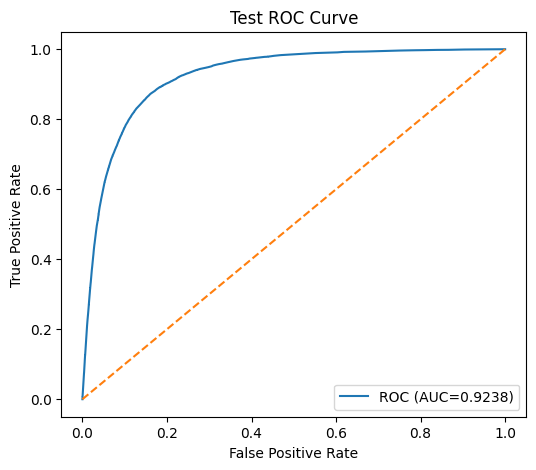

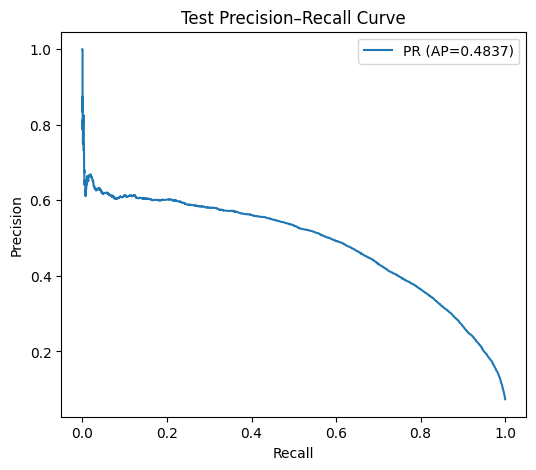

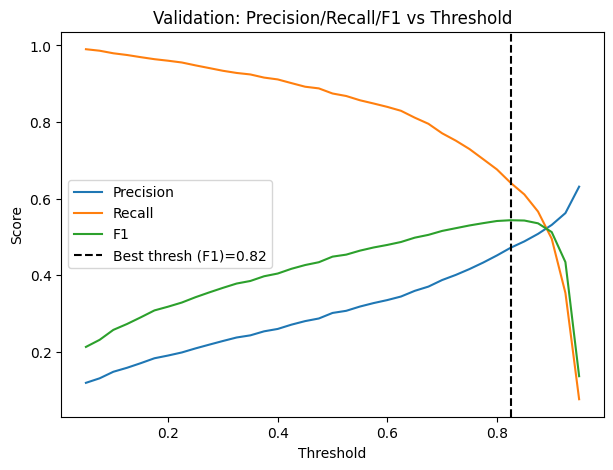

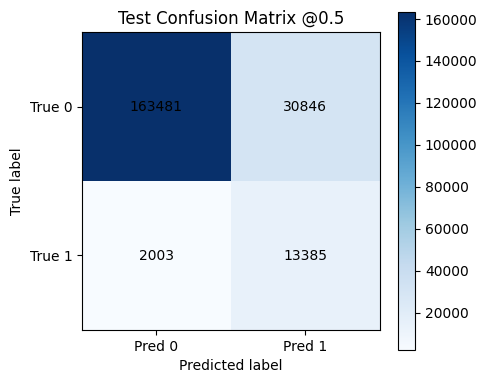

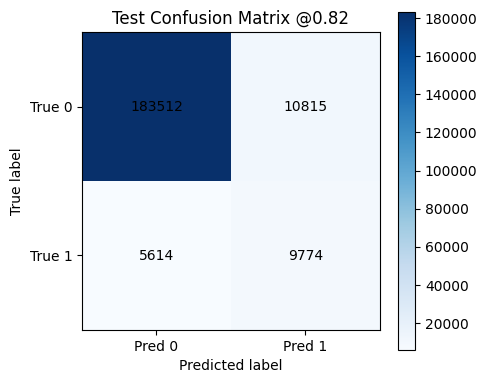

In [18]:
import matplotlib.pyplot as plt
from sklearn.metrics import (
    roc_curve, auc, precision_recall_curve, average_precision_score,
    confusion_matrix, f1_score, precision_score, recall_score, accuracy_score
)
import numpy as np

# ============================
# 확률 추출 (LightGBM: best_iteration_ 반영)
# ============================
_best_iter = getattr(final_model, "best_iteration_", None)
if _best_iter is not None and _best_iter > 0:
    val_prob_best = final_model.predict_proba(X_val,  num_iteration=_best_iter)[:, 1]
    test_prob     = final_model.predict_proba(X_test, num_iteration=_best_iter)[:, 1]
else:
    val_prob_best = final_model.predict_proba(X_val)[:, 1]
    test_prob     = final_model.predict_proba(X_test)[:, 1]

# ---------------------------
# 1) ROC Curve (Test)
# ---------------------------
fpr, tpr, _ = roc_curve(y_test, test_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"ROC (AUC={roc_auc:.4f})")
plt.plot([0,1],[0,1],"--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Test ROC Curve")
plt.legend()
plt.show()

# ---------------------------
# 2) Precision–Recall Curve (Test)
# ---------------------------
prec, rec, _ = precision_recall_curve(y_test, test_prob)
pr_auc = average_precision_score(y_test, test_prob)

plt.figure(figsize=(6,5))
plt.plot(rec, prec, label=f"PR (AP={pr_auc:.4f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Test Precision–Recall Curve")
plt.legend()
plt.show()

# ---------------------------
# 3) Threshold vs Precision/Recall/F1 (Validation 기준)
# ---------------------------
def curve_threshold_metrics(y_true, y_prob, grid=np.linspace(0.05,0.95,37)):
    precs, recs, f1s = [], [], []
    for t in grid:
        y_pred = (y_prob >= t).astype(int)
        precs.append(precision_score(y_true, y_pred, zero_division=0))
        recs.append(recall_score(y_true, y_pred))
        f1s.append(f1_score(y_true, y_pred))
    return grid, precs, recs, f1s

ts, precs, recs, f1s = curve_threshold_metrics(y_val, val_prob_best)

plt.figure(figsize=(7,5))
plt.plot(ts, precs, label="Precision")
plt.plot(ts, recs,  label="Recall")
plt.plot(ts, f1s,   label="F1")
plt.axvline(best_thresh, linestyle="--", color="k", label=f"Best thresh (F1)={best_thresh:.2f}")
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Validation: Precision/Recall/F1 vs Threshold")
plt.legend()
plt.show()

# ---------------------------
# 4) Confusion Matrix (Test @0.5 vs @best_thresh)
# ---------------------------
def plot_cm(y_true, y_prob, thr, title):
    y_pred = (y_prob >= thr).astype(int)
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(4.8,4.4))
    plt.imshow(cm, cmap="Blues")
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(2)
    plt.xticks(tick_marks, ["Pred 0","Pred 1"])
    plt.yticks(tick_marks, ["True 0","True 1"])
    for i in range(2):
        for j in range(2):
            plt.text(j, i, format(cm[i, j], "d"),
                     ha="center", va="center", color="black")
    plt.xlabel("Predicted label")
    plt.ylabel("True label")
    plt.show()

plot_cm(y_test, test_prob, 0.5, "Test Confusion Matrix @0.5")
plot_cm(y_test, test_prob, best_thresh, f"Test Confusion Matrix @{best_thresh:.2f}")
